In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import modules
import ddsp_textures.loss.functions
import ddsp_textures.auxiliar.filterbanks

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load audio to filter -----------------------------------
fire_path  = ".."+"/sounds/fire_sounds/fire.wav"
water_path = ".."+"/sounds/water_sounds/water.wav"
sr     = 44100
new_sr = sr // 4 # for log_bank
fire_audio, _  = librosa.load(fire_path, sr=sr)
fire_audio = fire_audio/np.max(np.abs(fire_audio))
water_audio, _ = librosa.load(water_path, sr=sr)
water_audio = water_audio/np.max(np.abs(water_audio))
# Make list of segments for fire and water --------------
frame_size     = 2**16
new_frame_size = frame_size // 4
hop_size   = 2**14
fire_segments = []
water_segments = []
for i in range(0, len(fire_audio)-frame_size, hop_size):
    # segment_norm = (fire_audio[i:i+frame_size] - np.mean(fire_audio[i:i+frame_size])) / np.std(fire_audio[i:i+frame_size])
    segment = fire_audio[i:i+frame_size]
    fire_segments.append(segment)
for i in range(0, len(water_audio)-frame_size, hop_size):
    # segment_norm = (water_audio[i:i+frame_size] - np.mean(water_audio[i:i+frame_size])) / np.std(water_audio[i:i+frame_size])
    segment = water_audio[i:i+frame_size]
    water_segments.append(segment)
# Initialize erb_bank and log_bank for statistics loss --
N_filter_bank = 16
M_filter_bank = 6
erb_bank    = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
log_bank    = ddsp_textures.auxiliar.filterbanks.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)

import torchaudio
downsampler = torchaudio.transforms.Resample(sr, new_sr).to(device)

In [11]:
#Testing Statistics functions --------------------------------------------------

fire_segment  = fire_segments[0]
water_segment = water_segments[0]
fire_segment  = torch.tensor(fire_segment).to(device)
water_segment = torch.tensor(water_segment).to(device)
fire_stats  = ddsp_textures.loss.functions.statistics_mcds(fire_segment,  N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
water_stats = ddsp_textures.loss.functions.statistics_mcds(water_segment, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
print("Fire statistics:\n")
print("stats_11_shape:", fire_stats[0].shape)
print("stats_12_shape:", fire_stats[1].shape)
print("stats_13_shape:", fire_stats[2].shape)
print("stats_14_shape:", fire_stats[3].shape)
print("stats_2_shape:",  fire_stats[4].shape)
print("stats_3_shape:",  fire_stats[5].shape)
print("stats_4_shape:",  fire_stats[6].shape)
print("stats_5_shape:",  fire_stats[7].shape)
print("stats_11:\n", fire_stats[0])
print("stats_12:\n", fire_stats[1])
print("stats_13:\n", fire_stats[2])
print("stats_14:\n", fire_stats[3])
print("stats_2:\n", fire_stats[4])
print("stats_3:\n", fire_stats[5])
print("stats_4:\n", fire_stats[6])
print("stats_5:\n", fire_stats[7])
print("\nWater statistics:\n")
print("stats_11:\n", water_stats[0])
print("stats_12:\n", water_stats[1])
print("stats_13:\n", water_stats[2])
print("stats_14:\n", water_stats[3])
print("stats_2:\n", water_stats[4])
print("stats_3:\n", water_stats[5])
print("stats_4:\n", water_stats[6])
print("stats_5:\n", water_stats[7])

Fire statistics:

stats_11_shape: torch.Size([1, 16])
stats_12_shape: torch.Size([1, 16])
stats_13_shape: torch.Size([1, 16])
stats_14_shape: torch.Size([1, 16])
stats_2_shape: torch.Size([1, 120])
stats_3_shape: torch.Size([1, 96])
stats_4_shape: torch.Size([1, 720])
stats_5_shape: torch.Size([1, 240])
stats_11:
 tensor([[0.0534, 0.0201, 0.0053, 0.0032, 0.0034, 0.0031, 0.0028, 0.0021, 0.0014,
         0.0013, 0.0012, 0.0011, 0.0012, 0.0015, 0.0019, 0.0009]],
       device='cuda:0')
stats_12:
 tensor([[ 0.6638,  0.8077,  0.8040,  1.8488,  2.5528, 12.5165, 19.8654, 22.0983,
         12.6093, 13.6021, 13.1758, 16.5555, 13.8440, 13.7600, 18.6201, 14.3294]],
       device='cuda:0')
stats_13:
 tensor([[ 0.7915,  1.2151,  1.0361,  3.8529,  5.3001, 10.5149, 12.8599, 12.3794,
          9.5979,  9.3422,  9.2879, 15.2187, 13.1057, 12.5677, 14.4655, 13.0129]],
       device='cuda:0')
stats_14:
 tensor([[  3.2706,   4.6416,   3.9887,  22.8414,  41.9597, 133.4304, 199.7104,
         201.8127, 124.6

In [12]:
# Make a size 2 batch
#Testing Statistics functions --------------------------------------------------

fire_segment  = fire_segments[0]
water_segment = water_segments[0]
fire_segment  = torch.tensor(fire_segment).to(device)
water_segment = torch.tensor(water_segment).to(device)
batch = torch.stack([fire_segment, water_segment])
print("Batch shape: ", batch.shape)
batch_stats  = ddsp_textures.loss.functions.statistics_mcds(batch,  N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
print("batch_stats:\n")
print("stats_11_shape:\n", batch_stats[0].shape)
print("stats_12_shape:\n", batch_stats[1].shape)
print("stats_13_shape:\n", batch_stats[2].shape)
print("stats_14_shape:\n", batch_stats[3].shape)
print("stats_2_shape:\n",  batch_stats[4].shape)
print("stats_3_shape:\n",  batch_stats[5].shape)
print("stats_4_shape:\n",  batch_stats[6].shape)
print("stats_5_shape:\n",  batch_stats[7].shape)
print("stats_11:\n", batch_stats[0])
print("stats_12:\n", batch_stats[1])
print("stats_13:\n", batch_stats[2])
print("stats_14:\n", batch_stats[3])
print("stats_2:\n",  batch_stats[4])
print("stats_3:\n",  batch_stats[5])
print("stats_4:\n",  batch_stats[6])
print("stats_5:\n",  batch_stats[7])

Batch shape:  torch.Size([2, 65536])
batch_stats:

stats_11_shape:
 torch.Size([2, 16])
stats_12_shape:
 torch.Size([2, 16])
stats_13_shape:
 torch.Size([2, 16])
stats_14_shape:
 torch.Size([2, 16])
stats_2_shape:
 torch.Size([2, 120])
stats_3_shape:
 torch.Size([2, 96])
stats_4_shape:
 torch.Size([2, 720])
stats_5_shape:
 torch.Size([2, 240])
stats_11:
 tensor([[0.0534, 0.0201, 0.0053, 0.0032, 0.0034, 0.0031, 0.0028, 0.0021, 0.0014,
         0.0013, 0.0012, 0.0011, 0.0012, 0.0015, 0.0019, 0.0009],
        [0.0149, 0.0132, 0.0167, 0.0208, 0.0239, 0.0276, 0.0300, 0.0270, 0.0216,
         0.0153, 0.0111, 0.0091, 0.0086, 0.0060, 0.0054, 0.0032]],
       device='cuda:0')
stats_12:
 tensor([[ 0.6638,  0.8077,  0.8040,  1.8488,  2.5528, 12.5165, 19.8654, 22.0983,
         12.6093, 13.6021, 13.1758, 16.5555, 13.8440, 13.7600, 18.6201, 14.3294],
        [ 0.2148,  0.8980,  0.7371,  1.1045,  0.8407,  0.5122,  0.5657,  0.4600,
          0.5178,  0.5927,  0.7570,  0.7526,  1.0983,  1.1490,  1.621

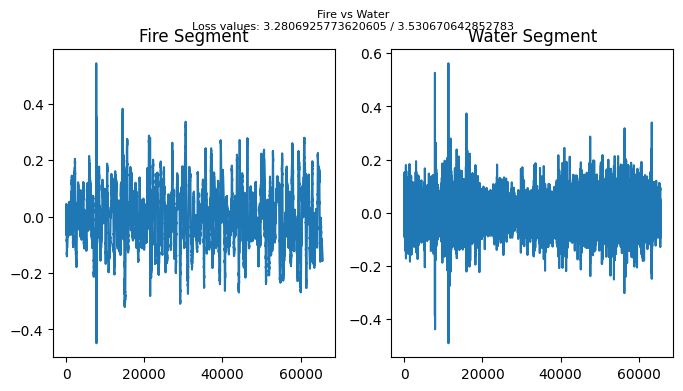

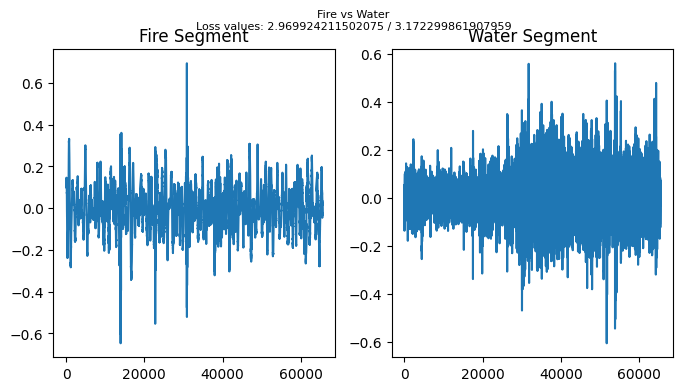

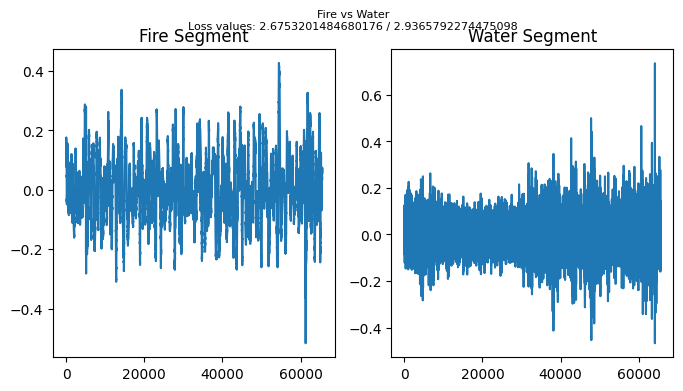

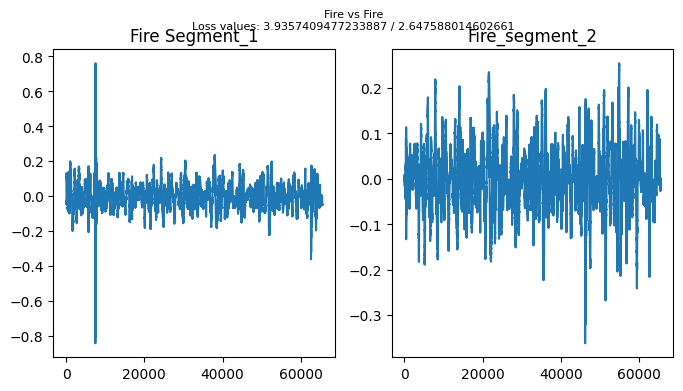

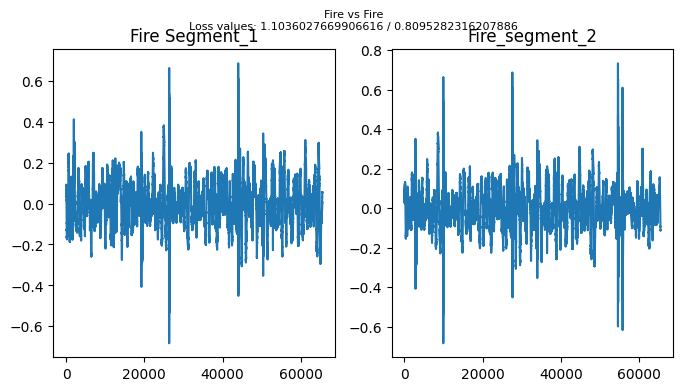

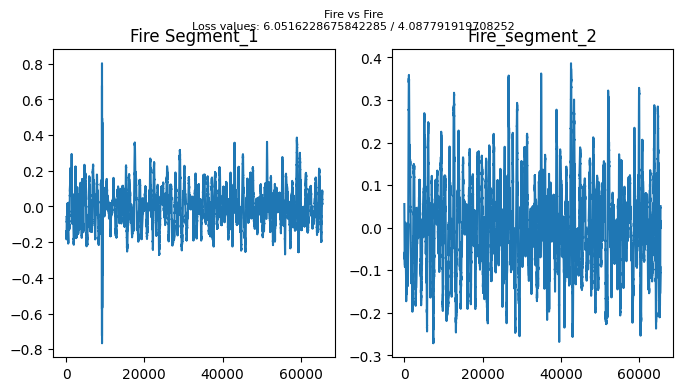

In [13]:
# Test Statistics loss function on three random pair of segments and plot them
for i in range(3):
    fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
    water_segment = water_segments[np.random.randint(len(water_segments))]
    #play water and fire segments
    display(Audio(fire_segment, rate=sr))
    display(Audio(water_segment, rate=sr))
    fire_segment  = torch.tensor(fire_segment).to(device)
    water_segment = torch.tensor(water_segment).to(device)
    loss_value_1 = ddsp_textures.loss.functions.statistics_loss(fire_segment, water_segment, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler, alpha = torch.tensor([0.3, 0.15, 0.1, 0.05, 0.1, 0.1, 0.1, 0.1]))
    loss_value_2 = ddsp_textures.loss.functions.statistics_loss(fire_segment, water_segment, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler, alpha = torch.tensor([0.0070, 0.0035, 0.8993, 0.0049, 0.0431, 0.0265, 0.0067, 0.0089]))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(fire_segment.cpu().numpy())
    ax1.set_title('Fire Segment')
    ax2.plot(water_segment.cpu().numpy())
    ax2.set_title('Water Segment')
    fig.suptitle(f'Fire vs Water\nLoss values: {loss_value_1} / {1.5*loss_value_2}', fontsize=8)
    plt.show()
# Test Statistics loss function on three random pair of fire
for i in range(3):
    index = np.random.randint(len(fire_segments)-1)
    fire_segment_1 = fire_segments[index]
    fire_segment_2 = fire_segments[index + 1]
    #play water and fire segments
    display(Audio(fire_segment_1, rate=sr))
    display(Audio(fire_segment_2, rate=sr))
    fire_segment_1 = torch.tensor(fire_segment_1).to(device)
    fire_segment_2 = torch.tensor(fire_segment_2).to(device)
    loss_value_1 = ddsp_textures.loss.functions.statistics_loss(fire_segment_1, fire_segment_2, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler, alpha = torch.tensor([0.3, 0.15, 0.1, 0.05, 0.1, 0.1, 0.1, 0.1]))
    loss_value_2 = ddsp_textures.loss.functions.statistics_loss(fire_segment_1, fire_segment_2, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler, alpha = torch.tensor([0.0070, 0.0035, 0.8993, 0.0049, 0.0431, 0.0265, 0.0067, 0.0089]))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(fire_segment_1.cpu().numpy())
    ax1.set_title('Fire Segment_1')
    ax2.plot(fire_segment_2.cpu().numpy())
    ax2.set_title('Fire_segment_2')
    fig.suptitle(f'Fire vs Fire\nLoss values: {loss_value_1} / {1.5*loss_value_2}', fontsize=8)
    plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

#Take 16 segments and make a batch
fire_batch = []
for i in range(32):
    fire_segment = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment = torch.tensor(fire_segment)
    fire_batch.append(fire_segment)
fire_batch = torch.stack(fire_batch, dim=0).to(device)

water_batch = []
for i in range(32):
    water_segment = water_segments[np.random.randint(len(water_segments))]
    water_segment = torch.tensor(water_segment)
    water_batch.append(water_segment)
water_batch = torch.stack(water_batch, dim=0).to(device)

start = time.time()
loss = ddsp_textures.loss.functions.statistics_loss(fire_batch, water_batch, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
end = time.time()
print("Time taken: ", end-start)
print("Batch loss value: ", loss)

start = time.time()
loss = ddsp_textures.loss.functions.multiscale_spectrogram_loss(fire_batch, water_batch)
end = time.time()
print("Time taken: ", end-start)
print("Batch loss value: ", loss)

Device:  cuda
Time taken:  0.20194196701049805
Batch loss value:  tensor(3.2864, device='cuda:0')
Time taken:  0.028868913650512695
Batch loss value:  tensor(16.1514, device='cuda:0')


In [15]:
# # Load audio to filter -----------------------------------
# fire_path  = ".."+"/sounds/fire_sounds/fire.wav"
# water_path = ".."+"/sounds/water_sounds/water.wav"
# sr     = 44100
# new_sr = sr // 4 # for log_bank
# fire_audio, _  = librosa.load(fire_path, sr=sr)
# water_audio, _ = librosa.load(water_path, sr=sr)
# # Make list of segments for fire and water --------------
# frame_size     = 2**15
# new_frame_size = frame_size // 4
# hop_size   = 2**15
# fire_segments = []
# water_segments = []
# for i in range(0, len(fire_audio)-frame_size, hop_size):
#     fire_segments.append(fire_audio[i:i+frame_size])
# for i in range(0, len(water_audio)-frame_size, hop_size):
#     water_segments.append(water_audio[i:i+frame_size])
# # Initialize erb_bank and log_bank for statistics loss --
# N_filter_bank = 32
# M_filter_bank = 20
# erb_bank    = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
# log_bank    = ddsp_textures.auxiliar.filterbanks.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)
# import torchaudio

# import ddsp_textures.loss
# downsampler = torchaudio.transforms.Resample(sr, new_sr)

# # pick random segments
# fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
# water_segment = water_segments[np.random.randint(len(water_segments))]
# fire_segment  = torch.tensor(fire_segment)
# water_segment = torch.tensor(water_segment)
# #play water and fire segments
# display(Audio(fire_segment, rate=sr))
# display(Audio(water_segment, rate=sr))
# # Compute stems
# from ddsp_textures.auxiliar.features import *
# stems_fire  = features_envelopes_stems(fire_segment, _, erb_bank)
# print("fire_shape: ", stems_fire.shape)
# stems_water = features_envelopes_stems(water_segment, _, erb_bank)
# print("water_shape: ", stems_water.shape)
# # Compute loss
# loss_value = ddsp_textures.loss.functions.statistics_loss_stems(stems_fire, stems_water, N_filter_bank, M_filter_bank, log_bank, downsampler)


In [16]:
# #Take 32 segments and make a batch
# fire_batch = []
# for i in range(32):
#     fire_segment = fire_segments[np.random.randint(len(fire_segments))]
#     fire_segment = torch.tensor(fire_segment)
#     fire_segment_stems = features_envelopes_stems(fire_segment, _, erb_bank)
#     fire_batch.append(fire_segment_stems)
# fire_batch = torch.stack(fire_batch, dim=0)

# print("fire_batch_shape:  ", fire_batch.shape)

# water_batch = []
# for i in range(32):
#     water_segment = water_segments[np.random.randint(len(water_segments))]
#     water_segment = torch.tensor(water_segment)
#     water_segment_stems = features_envelopes_stems(water_segment, _, erb_bank)
#     water_batch.append(water_segment_stems)
# water_batch = torch.stack(water_batch, dim=0)

# print("water_batch_shape: ", water_batch.shape)

# # compute the loss and tell me how much time it took
# import time
# start = time.time()
# loss = ddsp_textures.loss.functions.batch_statistics_loss_stems(fire_batch, water_batch, N_filter_bank, M_filter_bank, _, log_bank, downsampler)
# end = time.time()
# print("Time elapsed: ", end-start)
# print("Batch loss value: ", loss)